In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier as DFS

import warnings

from typing import List

warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 0. Некоторые полезные штуки

In [3]:
def isnan(value):
    return value is None or value != value

In [4]:
def analyze(series, categorical: bool = None):

  if isinstance(series, pd.DataFrame):
    series = series.iloc[:, 0]

  series_unique = sorted(series.unique())

  if categorical is None:
    categorical = len(series_unique) < 30


  max_len = 10

  print(
    f"unique: {len(series_unique)}",
    f"empty: {sum([isnan(el) for el in series])}",
    f"filled: {sum([not isnan(el) for el in series])},",
    f"values: {list(series_unique[:max_len]) + [] if len(series_unique) < max_len else ['...']}" if categorical else ""
  )
  if categorical:
    for val in series_unique[:max_len]:
      if isnan(val):
        print(f"{val} - {sum(series.isna())} times")
      else:
        print(f"{val} - {sum(series == val)} times")
    if len(series_unique) < 30:
      series.hist(xrot=-30)
  else:
    print(f"min: {series.min()}, mean: {series.mean()}, max: {series.max()}, std: {series.std()}")
    series.hist()
  plt.show()

# 1. Загружаем данные

In [5]:

filename = 'output.xlsx'


In [6]:
covid_contracts_positions_with_lot = pd.read_excel(filename)
print(list(covid_contracts_positions_with_lot.columns))
covid_contracts_positions_with_lot

['Unnamed: 0', 'contract_guid', 'contract_registration_number', 'notice_not_placed_by_fz223p5s4', 'contract_extension', 'contract_prolongation', 'customer_appeale_or_needs_approval', 'customer_approval_or_antimonopoly_descision_date', 'contract_plan_position_guid', 'contract_create_date_time', 'contract_customer_inn', 'contract_placer_inn', 'contract_detached_org_inn', 'contract_publication_date', 'contract_publication_date.1', 'emergency', 'provider', 'provider_code', 'contract_reg_number', 'contract_date', 'digital_purchase', 'purchase_notice_info_guid', 'purchase_notice_info_number', 'lot_guid', 'subject_contract', 'purchase_type_code', 'contract_price', 'contract_rub_price', 'contract_currency_code', 'contract_start_execution_date', 'contract_end_execution_date', 'region_name', 'notice_lot_initial_sum', 'notice_lot_starting_contract_price_rub', 'notice_lot_currency_code', 'notice_lot_commodity_price', 'notice_lot_commodity_price_rub', 'notice_lot_max_contract_price', 'notice_lot_ma

,Unnamed: 0,contract_guid,contract_registration_number,notice_not_placed_by_fz223p5s4,contract_extension,contract_prolongation,customer_appeale_or_needs_approval,customer_approval_or_antimonopoly_descision_date,contract_plan_position_guid,contract_create_date_time,contract_customer_inn,contract_placer_inn,contract_detached_org_inn,contract_publication_date,contract_publication_date.1,emergency,provider,provider_code,contract_reg_number,contract_date,digital_purchase,purchase_notice_info_guid,purchase_notice_info_number,lot_guid,subject_contract,purchase_type_code,contract_price,contract_rub_price,contract_currency_code,contract_start_execution_date,contract_end_execution_date,region_name,notice_lot_initial_sum,notice_lot_starting_contract_price_rub,notice_lot_currency_code,notice_lot_commodity_price,notice_lot_commodity_price_rub,notice_lot_max_contract_price,notice_lot_max_contract_price_rub,contract_is_complete,contract_position_name,position_okpd2_code,position_okpd2_name,position_country_code,position_producer_country,position_impossible_to_determine_attr,position_okei_code,position_okei_name,position_qty,position_unit_price,position_rub_unit_price,position_currency_code,contracts_for_lot,notice_customer_inn,notice_placer_inn,notice_detached_org_inn,contract_positions_count,supplier_inn,supplier_name,supplier_ogrn,supplier_type
0,0,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.00,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),4000.0,26.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
1,1,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.00,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),5000.0,26.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
2,2,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.00,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),1000.0,28.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
3,3,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.00,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),100.0,54.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
4,4,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b26

# 2. Предобработка данных

### Выбор признаков

#### оставляем только необходимые в дальнейшем признаки

In [7]:
features = [
    'contract_guid',
    'contract_is_complete',
    'contract_extension',  # [0, 1] Договором предусмотрена возможность продления срока действия договора после его окончания
    'purchase_type_code',  # ['400002', '400001', '300002', '300001', '110112', '120121', '110111'] Код признака закупки в электронном виде
    'notice_lot_max_contract_price',
    'notice_lot_initial_sum',
    'region_name',  # ['Sankt-Peterburg', 'Moskva', 'Krasnodarskii_krai', 'Moskovskaya_obl', 'Leningradskaya_obl', 'Primorskii_krai']
    'notice_lot_currency_code',  # ['RUB', 'EUR', 'CZK', 'USD', 'GBP', 'JPY', 'MNT']
    'position_okpd2_code',
    'position_okpd2_name',
    'position_impossible_to_determine_attr',  # [0, 1] Невозможно определить количество (объем)
    'supplier_inn', # ИНН поставщика
    'supplier_type', # Физик / Юрик
    'contract_placer_inn', # ИНН заказчика
    'contract_rub_price', # сумма контрактов в валюте переведенная в рубли
    'contract_price', # сумма рублевых контрактов
    'contract_start_execution_date', # Дата начала контракта
    'contract_end_execution_date', # Дата завершения контракта
    'notice_lot_currency_code',
    'contracts_for_lot', # Договоров на лот
    'contract_positions_count', # Позиций в договоре
    'lot_guid'

]

df = covid_contracts_positions_with_lot[features]
df = df.loc[:,~df.columns.duplicated()]
df.reset_index(drop=True, inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid
0,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
1,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
2,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
3,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
4,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8,706d8038-0c86-437b-b260-cb592f2fc8f9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80353,fff5ad7e-5884-46f1-9f07-4150e8cc6258,NaN,0,30000,NaN,365400.0,Amurskaya_obl,RUB,32.50.50.000,"Изделия медицинские, в том числе хирургические, прочие",0,NaN,NaN,2801022793,NaN,365400.00,2021-10-31,2021-11-09,1,1,71f694db-a9c7-404c-9eb8-bf7734b3c5d8
80354,fff6f724-be51-4180-930f-41999fdd5497,NaN,0,12012,NaN,686400.0,Saha_Jakutiya_Resp,RUB,21.20.10,Препараты лекарственные,1,NaN,NaN,1435149216,617760.0,617760.00,2021-11-24,2021-12-30,1,1,29810426-e8c0-40f8-bd32-9941017efaee
80355,fff8c702-ba6a-48c2-90d4-67c2c857cfd1,0.0,0,12012,NaN,23705828.4,Moskva,RUB,81.29.11.000,"Услуги по дезинфекции, дезинсекции и дератизации",0,NaN,NaN,7725038124,NaN,3200287.08,2020-11-16,NaN,1,1,a8bf48e0-feca-41a8-9193-64987e562e9d
80356,fffb9623-244a-4c27-b1c7-4518ab6412bd,1.0,0,40000,NaN,600600.0,Saha_Jakutiya_Resp,RUB,21.20.10,Препараты лекарственные,0,NaN,NaN,1431004812,NaN,600600.00,2021-07-06,2021-12-30,1,1,89d200ae-e338-463b-89b3-0cf5955eee3c


#### Убираем тех, у кого нет ИНН поставщика

In [8]:
df.dropna(subset=['supplier_inn'], inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid
53,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"Оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea
57,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"Изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d
97,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,Одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc
109,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508
2307,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,Антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80125,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"Реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772
80126,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"Изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772
80258,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,Услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f
80260,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c


#### Определяем стоимость договора в рублях и начальную цену договора

In [9]:
df['real_rub_price'] = df.apply(
    lambda row: row['contract_rub_price'] if not isnan(row['contract_rub_price']) else row['contract_price'],
    axis=1
)

df['real_initial_sum'] = df.apply(
    lambda row: row['notice_lot_max_contract_price'] if not isnan(row['notice_lot_max_contract_price']) else row['notice_lot_initial_sum'],
    axis=1
)

#### Убираем строки где нет начальной цены

In [10]:
df.dropna(subset=['real_initial_sum'], inplace=True)
df.drop(df[df['real_initial_sum'] == 0].index, inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum
53,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"Оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00
57,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"Изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76
97,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,Одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00
109,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00
2307,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,Антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80125,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"Реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52
80126,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"Изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52
80258,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,Услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60
80260,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00


#### Приводим описание okpd2 к нижнему регистру

In [11]:
df['position_okpd2_name'] = df.apply(
    lambda row: str(row['position_okpd2_name']).lower(), axis=1
)

#### Определяем вид *ПОЗИЦИИ* по окпд2


In [12]:
def category(row):
  if row['position_okpd2_code'][:2] in ['37', '38', '61', '62', '80', '81', '82', '84', '95','96']:
      if 'услуги' in row['position_okpd2_name']:# это условие собирает ок
          return 'ХозУслуги'
      else:
          return 'МедУслуги'# ok
  elif row['position_okpd2_code'][:2] in ['05', '08', '16', '24', '25', '36', '41', '42', '43', '47', '71']:
      if ('перевооруж' in row['position_okpd2_name']
          or 'ремонт' in row['position_okpd2_name']
          or 'замена' in row['position_okpd2_name']
          or 'работы' in row['position_okpd2_name']) and ('элект' in row['position_okpd2_name'] or 'отопл' in row['position_okpd2_name']
                                                          or  'водопров' in row['position_okpd2_name'] or  'газов' in row['position_okpd2_name']
                                                           or 'рельс' in row['position_okpd2_name']):
          return 'ХозУслуги'#ok
      elif ('перевооруж' in row['position_okpd2_name']
          or 'ремонт' in row['position_okpd2_name']
          or 'замена' in row['position_okpd2_name']
          or 'работы' in row['position_okpd2_name']) and not ('элект' in row['position_okpd2_name'] or 'отопл' in row['position_okpd2_name']
                                                          or  'водопров' in row['position_okpd2_name'] or  'газов' in row['position_okpd2_name']
                                                           or 'рельс' in row['position_okpd2_name']):
          return 'Строительство'#ok
      elif ('емкости из' in row['position_okpd2_name'] or 'ферросплавы' in row['position_okpd2_name'] or 'винты' in row['position_okpd2_name']
             or 'котлы' in row['position_okpd2_name']  or 'проволок' in row['position_okpd2_name']  or 'труб' in row['position_okpd2_name']
            or 'электрод' in row['position_okpd2_name'] or 'труб' in row['position_okpd2_name']
            ):
        return 'ХозМат'#ok

      else:
          return 'ХозУслуги'#ok
  elif row['position_okpd2_code'][:2] in ['13', '14', '15', '20', '21', '22' , '23']:
      if ('медицин' in row['position_okpd2_name'] or 'маск' in row['position_okpd2_name'] or 'комбинез' in row['position_okpd2_name']
    or 'анальг' in row['position_okpd2_name'] or 'анест' in row['position_okpd2_name'] or 'антибиот' in row['position_okpd2_name'] or 'антисепт' in row['position_okpd2_name']
    or 'вазодил' in row['position_okpd2_name'] or 'стероид' in row['position_okpd2_name'] or 'гормон' in row['position_okpd2_name'] or 'добавки' in row['position_okpd2_name']
    or 'имуно' in row['position_okpd2_name'] or 'кислород' in row['position_okpd2_name'] or 'микроорганизм' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name']
    or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name']
    or 'пеницил' in row['position_okpd2_name'] or 'хирург' in row['position_okpd2_name'] or 'антианемич' in row['position_okpd2_name'] or 'антибактериал' in row['position_okpd2_name']
    or 'гематолог' in row['position_okpd2_name'] or 'препарат' in row['position_okpd2_name'] or 'налептик' in row['position_okpd2_name'] or 'плазмо' in row['position_okpd2_name']
    or 'нуклеин' in row['position_okpd2_name'] or 'диагност' in row['position_okpd2_name'] or 'спирт' in row['position_okpd2_name'] or 'дезинфекц' in row['position_okpd2_name']
    or 'средства защиты' in row['position_okpd2_name'] or 'фармацевт' in row['position_okpd2_name'] or 'сыворотк' in row['position_okpd2_name'] or 'цефалоспор' in row['position_okpd2_name']
    or 'эфир' in row['position_okpd2_name'] or 'антикоаг' in row['position_okpd2_name'] or 'контраст' in row['position_okpd2_name'] or 'химич' in row['position_okpd2_name']
    or 'иммун' in row['position_okpd2_name'] or 'индикатор' in row['position_okpd2_name']):
          return 'МедМат'#ok
      else:
          return 'ХозМат'#ok
  elif row['position_okpd2_code'][:2] in ['26', '27', '28', '32']:
      if ('протез' in row['position_okpd2_name'] or 'респиратор' in row['position_okpd2_name'] or 'средства защит' in row['position_okpd2_name']
          or 'средства индив' in row['position_okpd2_name'] or 'термометр' in row['position_okpd2_name'] or 'шприц' in row['position_okpd2_name']):
        return 'МедМат'#ok
      elif ('специального назн' in row['position_okpd2_name'] or 'рентген' in row['position_okpd2_name'] or 'медиц' in row['position_okpd2_name']
            or 'терапевт' in row['position_okpd2_name'] or 'дыхател' in row['position_okpd2_name'] or 'фильтров' in row['position_okpd2_name']
             or 'центрифуг' in row['position_okpd2_name'] or 'кардио' in row['position_okpd2_name'] or 'диагност' in row['position_okpd2_name']
            or 'ультрафиолет' in row['position_okpd2_name'] or 'терапии' in row['position_okpd2_name']):
          return 'МедОбор'#ok
      elif ('аппарат' in row['position_okpd2_name'] or 'компьютер' in row['position_okpd2_name'] or 'оборуд' in row['position_okpd2_name']
            or 'насос' in row['position_okpd2_name'] or 'трансформатор' in row['position_okpd2_name'] or 'устройств' in row['position_okpd2_name']
            or 'экспоном' in row['position_okpd2_name'] or 'редуктор' in row['position_okpd2_name'] or 'средств' in row['position_okpd2_name']
            or 'установк' in row['position_okpd2_name'] or 'машин' in row['position_okpd2_name']):
        return 'ХозОбор'#ok
      else:
          return 'ХозМат'#ok
  elif row['position_okpd2_code'][:2] in ['01' , '10' , '11', '46', '56']:
    if ('машин' in row['position_okpd2_name']):
      return 'ХозОбор'#ok
    elif ('водопровод' in row['position_okpd2_name']):
      return 'ХозМат'#ok
    elif ('фармац' in row['position_okpd2_name']):
      return 'МедМат'#ok
    else:
      return 'Еда'   #ok
  elif row['position_okpd2_code'][:2] in  ['33', '52', '65', '72', '86']:
    if ('больн' in row['position_okpd2_name'] or 'медиц' in row['position_okpd2_name'] or 'врач' in row['position_okpd2_name'] ):
          return 'МедУслуги'#ok
    else:
      return 'ХозУслуги'#ok
  elif row['position_okpd2_code'][:2] in ['19', '29', '30', '45', '49', '51']:

    return 'Другое'

  return 'Другое'


df['position_category'] = df.apply(lambda row: category(row), axis=1)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category
53,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,ХозОбор
57,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,МедОбор
97,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,ХозМат
109,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,МедМат
2307,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,МедМат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80125,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,МедМат
80126,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,ХозМат
80258,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,Другое
80260,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,МедМат


#### Определяем вид *ДОГОВОРА* по позициям

##### Объединяем все встречающиеся типы позиций договора в список

In [13]:
contract_columns = df.columns.to_list()

contract_columns.remove('position_okpd2_code')
contract_columns.remove('position_okpd2_name')
contract_columns.remove('position_category')
contract_columns.remove('position_impossible_to_determine_attr')
contract_columns

['contract_guid',
 'contract_is_complete',
 'contract_extension',
 'purchase_type_code',
 'notice_lot_max_contract_price',
 'notice_lot_initial_sum',
 'region_name',
 'notice_lot_currency_code',
 'supplier_inn',
 'supplier_type',
 'contract_placer_inn',
 'contract_rub_price',
 'contract_price',
 'contract_start_execution_date',
 'contract_end_execution_date',
 'contracts_for_lot',
 'contract_positions_count',
 'lot_guid',
 'real_rub_price',
 'real_initial_sum']

In [14]:
df = df.groupby(contract_columns, dropna=False)['position_category'].apply(list).reset_index()
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор]
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор]
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат]
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат]
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]"
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]"
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое]
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат]


##### Выбираем в кочестве типа договора самый частый тип позиции
при этом, если самая частая позиция - Другое и есть что-то ещё, отбрасываем категорию другое

In [15]:
def get_most_frequent_category(category_okpd: List[str]) -> str:
    category_dict = {}
    for _category in category_okpd:
        category_dict[_category] = category_dict.get(_category, 0) + 1

    most_frequent_category = ''
    _max_count = 0
    _items_count = len(category_dict)
    for _category, _count in category_dict.items():
        if _items_count != 1 and _category == 'Другое':
            continue
        if _count > _max_count:
            most_frequent_category = _category
            _max_count = _count
    return most_frequent_category

In [16]:
df['contract_category'] = df['position_category'].map(get_most_frequent_category)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат


unique: 9 empty: 0 filled: 2891, values: ['Другое', 'Еда', 'МедМат', 'МедОбор', 'МедУслуги', 'Строительство', 'ХозМат', 'ХозОбор', 'ХозУслуги']
Другое - 134 times
Еда - 57 times
МедМат - 1099 times
МедОбор - 300 times
МедУслуги - 227 times
Строительство - 133 times
ХозМат - 361 times
ХозОбор - 55 times
ХозУслуги - 525 times


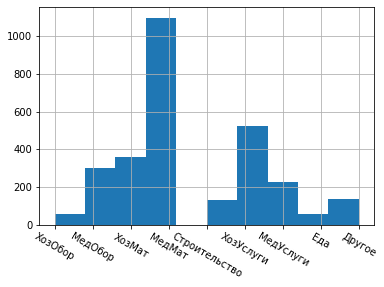

In [17]:
analyze(df['contract_category'], categorical=True)

unique: 2 empty: 0 filled: 2891, values: [30000, 40000]
30000 - 783 times
40000 - 2108 times


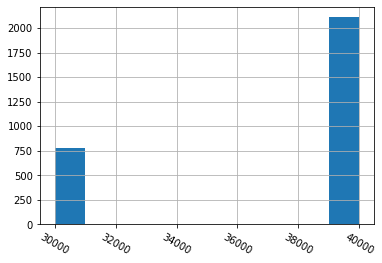

In [18]:
analyze(df['purchase_type_code'], categorical=True)

# 3. Считаем новые признаки

### Экономия по лоту

In [19]:
df[df['contracts_for_lot'] > 1]

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category
31,023f65b9-7adf-4132-a5d4-b7c945c1e1d7,1.0,0,40000,NaN,9554240.00,Moskva,RUB,7.112501e+09,Юридическое лицо,7705035012,NaN,605748.50,2021-05-30,2021-07-30,14,1,e60ffec4-fccc-4a02-8207-97226dc13120,605748.50,9554240.00,[ХозУслуги],ХозУслуги
84,07b2541b-36b3-404f-949a-48a8def2dae3,1.0,0,40000,NaN,1038434.20,Moskva,RUB,2.310219e+09,Юридическое лицо,7713059497,NaN,98700.00,2021-07-12,2021-12-30,4,3,7ba963f0-49a1-38bc-6286-50e5d46746eb,98700.00,1038434.20,"[ХозМат, ХозМат, ХозМат]",ХозМат
229,14664be9-631c-4186-9ad7-7b5e14491e2f,1.0,0,40000,NaN,48600000.00,Volgogradskaya_obl,RUB,5.017112e+09,Юридическое лицо,3443012297,NaN,48600000.00,2020-11-10,2020-12-30,2,1,08fcfa39-dd35-45fc-a7fe-8856ab5a7f68,48600000.00,48600000.00,[МедМат],МедМат
315,1ce1dd6d-7c16-4a2b-93c8-0f073e3d51df,NaN,0,40000,NaN,78000000.00,Brianskaya_obl,RUB,5.050138e+09,Юридическое лицо,3201000327,NaN,500000.00,2020-07-27,2021-01-30,11,1,a131334e-6bae-42bf-9696-e1968292b25b,500000.00,78000000.00,[МедОбор],МедОбор
365,21c5c05d-e69e-4c53-9b35-924840cc8850,NaN,0,30000,NaN,228551.10,Ulianovskaya_obl,RUB,7.326024e+09,Юридическое лицо,7328041152,NaN,228551.10,2020-03-31,2020-12-30,2,11,c71a36e1-440a-4fe6-9e15-8bae2f6d0e53,228551.10,228551.10,"[Еда, ХозМат, Еда, Еда, Еда, Еда, Еда, Еда, Еда, Еда, Еда]",Еда
429,26fd2ec7-22d1-47ca-853f-b4665c34fee1,NaN,0,40000,NaN,9554240.00,Moskva,RUB,7.112501e+09,Юридическое лицо,7705035012,NaN,1658534.99,2021-05-30,2021-07-30,14,1,e60ffec4-fccc-4a02-8207-97226dc13120,1658534.99,9554240.00,[ХозУслуги],ХозУслуги
500,2cf271ca-50e9-41e9-9c0e-7f587fc564c9,NaN,0,40000,NaN,78000000.00,Brianskaya_obl,RUB,5.050138e+09,Юридическое лицо,3201000327,NaN,500000.00,2020-07-27,2021-01-30,11,1,a131334e-6bae-42bf-9696-e1968292b25b,500000.00,78000000.00,[МедОбор],МедОбор
675,3b2f18f0-23d5-497c-96a5-4170a35a34ac,NaN,0,40000,NaN,625170.00,Nizhegorodskaya_obl,RUB,6.234166e+09,Юридическое лицо,5260200603,NaN,625170.00,2020-04-14,2020-11-30,2,1,40602db8-8636-4dad-b84b-0733f5c8e64d,625170.00,625170.00,[ХозУслуги],ХозУслуги
688,3c3d9907-712b-462c-bec8-38b35592c375,NaN,0,40000,NaN,9554240.00,Moskva,RUB,7.112501e+09,Юридическое лицо,7705035012,NaN,235442.30,2021-05-24,2021-07-30,14,1,e60ffec4-fccc-4a02-8207-97226dc13120,235442.30,9554240.00,[ХозУслуги],ХозУслуги
720,3fb78c77-8c79-4de7-9fba-4e4ac1192ac9,NaN,0,40000,NaN,78000000.00,Brianskaya_obl,RUB,5.050138e+09,Юридическое лицо,3201000327,NaN,7000000.00,2020-07-27,2021-01-30,11,1,a131334e-6bae-42bf-9696-e1968292b25b,7000000.00,78000000.00,[МедОбор],МедОбор


Существуют лоты, на которые было заключено более одного договора

##### Абсолютная экономия по лоту

unique: 432 empty: 0 filled: 2891, 
min: -48600000.0, mean: 72498.68751297127, max: 39514475.95000005, std: 2083071.2153252258


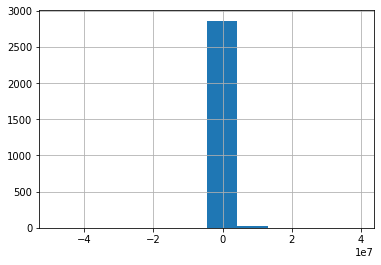

In [20]:
df['economy'] = df.apply(
    lambda row, df_tmp: row['real_initial_sum'] - df_tmp[df_tmp["lot_guid"] == row["lot_guid"]]["real_rub_price"].sum(),
    args=[df], axis=1
)

analyze(df['economy'], categorical=False)

##### Относительная

unique: 417 empty: 0 filled: 2891, 
min: -86.06770029673591, mean: -0.1229086688942206, max: 1.0, std: 3.3511051980675925


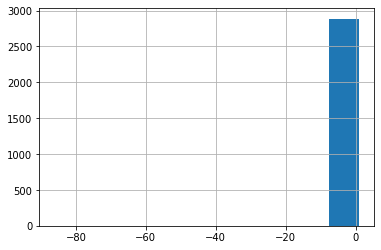

In [21]:
df['economy_percent'] = df.apply(
    lambda row: row['economy'] / row['real_initial_sum'],
    axis=1
)

analyze(df['economy_percent'], categorical=False)

In [22]:
df[df['economy'] < 0]

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent
65,061f80c4-fb14-477a-b884-af2f7f16187b,1.0,0,40000,NaN,245435.40,Ulianovskaya_obl,RUB,7.317002e+09,Юридическое лицо,7328014430,NaN,269978.94,2020-10-14,2020-12-30,1,1,f816091a-e8c7-4989-9e7c-c8a195ac60d1,269978.94,245435.40,[Другое],Другое,-24543.54,-0.100000
76,070fc19f-3668-473e-859b-aef4041cb498,NaN,0,40000,NaN,2700368.55,Kurskaya_obl,RUB,4.634010e+09,Юридическое лицо,4632060153,NaN,4074370.90,2020-03-19,2021-03-19,1,1,9eacd8a0-9d9f-421e-9651-d2784e3a7e92,4074370.90,2700368.55,[ХозУслуги],ХозУслуги,-1374002.35,-0.508820
155,0e086a12-60c8-4170-b0fa-024dad47eed7,1.0,0,40000,NaN,11160000.00,Saha_Jakutiya_Resp,RUB,1.435149e+09,Юридическое лицо,1435167374,NaN,13392000.00,2020-04-19,2020-04-29,1,1,db5e7689-16a9-4b7f-a61b-cd0f472c8fd1,13392000.00,11160000.00,[МедМат],МедМат,-2232000.00,-0.200000
171,0f1283d4-ff04-4e59-8e5d-457ad0b519ff,1.0,0,30000,NaN,700700.00,Sankt-Peterburg,RUB,7.813276e+09,Юридическое лицо,7830001028,NaN,840840.00,2020-11-19,2021-01-29,1,1,10da16ad-61ad-49f6-a9de-b16bb8b75ef3,840840.00,700700.00,[ХозУслуги],ХозУслуги,-140140.00,-0.200000
203,12100447-4e42-2020-0000-000000001475,1.0,0,40000,NaN,4074803.25,Jamalo-Nenetckii_AO,RUB,1.435243e+09,Юридическое лицо,8905026850,7020805.75,7020805.75,2020-05-05,2020-06-09,1,1,5109cfa2-149c-1eda-a2bf-ac7494a55a1d,7020805.75,4074803.25,[ХозУслуги],ХозУслуги,-2946002.50,-0.722980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,f36b3899-31ce-4d1e-a5b9-c1a0d4afd47b,NaN,0,40000,NaN,24592787.47,Arhangelskaya_obl,RUB,2.901240e+09,Юридическое лицо,7726747370,NaN,20639880.42,2021-09-30,2021-12-29,2,1,72b19591-a9c2-4f24-9261-6d272fb83247,20639880.42,24592787.47,[Строительство],Строительство,-16686973.37,-0.678531
2758,f3e1d2ff-35bc-4460-b951-648e928fc390,1.0,0,40000,NaN,924000.00,Moskva,RUB,7.724212e+09,Юридическое лицо,7717022723,1078000.00,1078000.00,2020-12-31,2021-07-30,1,1,33a72d78-b1a3-424d-9546-b066601a06a3,1078000.00,924000.00,[ХозУслуги],ХозУслуги,-154000.00,-0.166667
2815,f7f3dffa-a6e2-4bfb-8f6b-7945f055f242,1.0,0,30000,NaN,118830.00,Tiumenskaya_obl,RUB,7.203462e+09,Юридическое лицо,7224013707,NaN,157250.00,2020-06-07,2020-09-29,1,1,0681948e-e310-4723-adaa-f35f4c7bdf25,157250.00,118830.00,[МедМат],МедМат,-38420.00,-0.323319
2849,fbab9be5-1222-4fda-ab01-95048048f816,1.0,0,40000,NaN,715919.77,Saha_Jakutiya_Resp,RUB,1.431031e+11,Физическое лицо,1435218580,NaN,745536.80,2020-05-31,2020-06-29,1,1,9808bc4e-f70e-4045-be70-fab2bfa4b2d3,745536.80,715919.77,[ХозУслуги],ХозУслуги,-29617.03,-0.041369


In [23]:
df[df['economy_percent'] != 0]

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent
11,00cf4cd6-96ea-438d-9cd2-75ccf02fc0c5,NaN,0,40000,NaN,30833.33,Magadanskaya_obl,RUB,1.101097e+11,Физическое лицо,4909032631,NaN,23127.00,2020-11-22,2021-02-27,1,1,6ae23cf0-2b31-9d69-68ad-09ad20bde981,23127.00,30833.33,[ХозМат],ХозМат,7706.33,0.249935
15,00deaf00-6149-44d2-83c3-64810914139b,0.0,0,40000,NaN,873000.00,Sverdlovskaya_obl,RUB,6.685024e+09,Юридическое лицо,6664033808,NaN,610200.00,2020-05-27,2020-12-30,1,1,2fda9130-0b7e-4beb-8b82-ca5a622a851d,610200.00,873000.00,[МедМат],МедМат,262800.00,0.301031
27,01a23287-797a-4d6e-ae2e-b28507e00448,NaN,0,40000,NaN,3509163.40,Sverdlovskaya_obl,RUB,6.678089e+09,Юридическое лицо,6608001915,NaN,1978413.04,2021-02-15,2022-01-30,1,23,2f43cf71-c809-59ad-98ec-896dd685ecb6,1978413.04,3509163.40,"[ХозМат, МедМат, ХозМат, ХозМат, ХозМат, ХозМат, Другое, ХозМат, ХозМат, Другое, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, ХозМат, МедМат, Другое, ХозМат, МедМат]",ХозМат,1530750.36,0.436215
29,01d01d05-f18b-4db1-a549-35d785f5be25,1.0,0,40000,NaN,240000.00,Primorskii_krai,RUB,2.536111e+09,Юридическое лицо,2540252341,NaN,234000.00,2021-03-25,2021-12-30,1,1,7045d015-9e8f-12bd-dcea-6d10c4ac5308,234000.00,240000.00,[ХозУслуги],ХозУслуги,6000.00,0.025000
47,03ffec77-6df7-49d3-bf4b-184c21dcba6f,1.0,0,40000,NaN,190581.55,Permskii_krai,RUB,5.904122e+09,Юридическое лицо,5948013899,NaN,158817.96,2019-12-31,2020-12-30,1,2,225d658d-6a57-4d53-8d8c-6629f206c63e,158817.96,190581.55,"[ХозУслуги, ХозУслуги]",ХозУслуги,31763.59,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874,fe574a2d-e296-438b-a481-1eb0138e4254,1.0,0,40000,NaN,500000.00,Moskva,RUB,7.728709e+09,Юридическое лицо,7729101120,NaN,307500.00,2020-10-25,2020-12-30,1,1,0acdfafd-7b58-46bd-9521-483b3039dbd9,307500.00,500000.00,[МедМат],МедМат,192500.00,0.385000
2877,fe9ca78d-e23a-4d03-b8d7-39660a2c37e4,1.0,0,30000,NaN,150000.00,Hanty-Mansiiskii_AO_Iugra_AO,RUB,8.603158e+09,Юридическое лицо,8602002480,NaN,148200.00,2021-02-17,2021-12-30,1,1,3cf9086d-8141-47e1-ab5e-e5b837ef72d4,148200.00,150000.00,[МедМат],МедМат,1800.00,0.012000
2880,fee2c8ba-178d-4afb-ad14-58223b281445,1.0,0,30000,NaN,378635.00,Brianskaya_obl,RUB,7.727663e+09,Юридическое лицо,3234013184,NaN,359129.10,2021-06-10,2021-08-30,1,1,fdf6afa5-df7e-46c2-ac0b-3455fe5f6d75,359129.10,378635.00,[МедМат],МедМат,19505.90,0.051516
2881,fee6970b-505a-4e7d-bdae-3ebbabb7e723,1.0,0,40000,NaN,1500000.00,Moskva,RUB,7.707300e+09,Юридическое лицо,7729101120,NaN,222615.00,2020-10-19,2020-12-30,1,1,3600b5fa-979b-4926-9694-3b5a4c15afd8,222615.00,1500000.00,[МедМат],МедМат,1277385.00,0.851590


### Считаем признаки для пары поставщик-заказчик

##### % контрактов поставщика у заказчика относительно всех контрактов поставщика

всего договоров у заказчика

In [24]:
df['total_placer_contracts'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]].shape[0], args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2


всего договоров заказчика с поставщиком

In [25]:
df['total_placer_with_supplier_contracts'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
        [df["supplier_inn"] == row["supplier_inn"]].shape[0], args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2


Процент договоров, которые заказчик заключил с конкретным поставщиком

In [26]:
df['percent_placer_with_supplier_contracts'] = df.apply(
    lambda row: row['total_placer_with_supplier_contracts'] / row['total_placer_contracts'], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000


##### % контрактов заказчика с поставщиком относительно всех контрактов заказчика

Всего договоров у заказчика

In [27]:
df['total_supplier_contracts'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["supplier_inn"] == row["supplier_inn"]].shape[0], args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500,11
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2


Процент договоров, которые поставщик заключил с конкретным заказчиком

In [28]:
df['percent_supplier_with_placer_contracts'] = df.apply(
    lambda row: row['total_placer_with_supplier_contracts'] / row['total_supplier_contracts'], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000


##### максимальное количество позиций в лоте для пары

In [29]:
df['max_contract_positions_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
        [df["supplier_inn"] == row["supplier_inn"]]['contract_positions_count'].max(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1


##### среднее количество позиций в лоте

In [30]:
df['mean_contract_positions_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
        [df["supplier_inn"] == row["supplier_inn"]]['contract_positions_count'].mean(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4,1.727273
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000


##### общая сумма договоров между заказчиком и поставщиком

In [31]:
df['total_contract_sum_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
    [df["supplier_inn"] == row["supplier_inn"]]['real_rub_price'].sum(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4,1.727273,6555490.00
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00


##### средняя сумма договоров между заказчиком и поставщиком

In [32]:
df['mean_contract_sum_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
    [df["supplier_inn"] == row["supplier_inn"]]['real_rub_price'].mean(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4,1.727273,6555490.00,5.959536e+05
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00,4.864000e+05


##### минимальная экономия по лоту

In [33]:
df['min_economy_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
    [df["supplier_inn"] == row["supplier_inn"]]['economy_percent'].min(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4,1.727273,6555490.00,5.959536e+05,0.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00,4.864000e+05,-0.247667


##### средняя экономия по лоту

In [34]:
df['mean_economy_placer_supplier'] = df.apply(
    lambda row, df_tmp: df_tmp[df_tmp["contract_placer_inn"] == row["contract_placer_inn"]]
    [df["supplier_inn"] == row["supplier_inn"]]['economy_percent'].mean(), args=[df], axis=1
)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,[ХозОбор],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000,0.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,[МедОбор],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000,0.000000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,[ХозМат],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000,0.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,[МедМат],МедМат,0.0,0.000000,16,11,0.687500,11,1.000000,4,1.727273,6555490.00,5.959536e+05,0.000000,0.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,[МедМат],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000,0.000000
2887,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"[МедМат, ХозМат]",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000,0.000000
2888,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,[Другое],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000,0.000000
2889,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,[МедМат],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00,4.864000e+05,

# 4. Выгрузим данные в файл

In [35]:
df.to_excel("dataset.xlsx", index=False)